In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Imports

In [ ]:
import os
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn 
from torch.autograd import Variable

import torchvision
from torchvision import datasets, transforms

import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt

Loading Dataset from Directory

In [ ]:

batch_size = 100
transform_train_test = transforms.Compose([
    transforms.ToTensor(),
])

dataset_path = "/content/drive/MyDrive/Research/GTZAN_Adversarial/images_original/"

original_dataset = torchvision.datasets.ImageFolder(root=dataset_path, transform = transforms.Compose([transforms.Resize([32, 32]),transforms.ToTensor()]))
classes = ('blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock')


In [ ]:
#Train test split from dataset
n = len(original_dataset)  # total number of examples
n_test = int(0.35 * n)  # take ~33% for test
test_set = torch.utils.data.Subset(original_dataset, range(n_test))  # take first 10%
train_set = torch.utils.data.Subset(original_dataset, range(n_test, n))  # take the rest   

In [ ]:
# Dataloader declaration
trainloader = torch.utils.data.DataLoader(train_set,batch_size=100, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test_set,batch_size=100, shuffle=True, num_workers=2)


## Model Architecture


In [ ]:
class VGG16(nn.Module):
  def __init__(self):
    super(VGG16,self).__init__()

    self.block1 = nn.Sequential(
                  nn.Conv2d(in_channels = 3,out_channels = 64,kernel_size = 3,padding = 1),
                  nn.BatchNorm2d(64),
                  nn.ReLU(),
                  nn.Conv2d(in_channels = 64,out_channels = 64,kernel_size = 3, padding =1),
                  nn.BatchNorm2d(64),
                  nn.ReLU(),
                  nn.MaxPool2d(kernel_size=2, stride=2),
                  nn.Dropout2d(0.3))

    self.block2 = nn.Sequential(
                  nn.Conv2d(in_channels = 64,out_channels = 128,kernel_size = 3,padding = 1),
                  nn.BatchNorm2d(128),
                  nn.ReLU(),
                  nn.Conv2d(in_channels = 128,out_channels = 128,kernel_size = 3, padding =1),
                  nn.BatchNorm2d(128),
                  nn.ReLU(),
                  nn.MaxPool2d(kernel_size=2, stride=2),
                  nn.Dropout2d(0.4))

    self.block3 = nn.Sequential(
                  nn.Conv2d(in_channels = 128,out_channels = 256,kernel_size = 3,padding = 1),
                  nn.BatchNorm2d(256),
                  nn.ReLU(),
                  nn.Conv2d(in_channels = 256,out_channels = 256,kernel_size = 3,padding = 1),
                  nn.BatchNorm2d(256),
                  nn.ReLU(),
                  nn.Conv2d(in_channels = 256,out_channels = 256,kernel_size = 3, padding =1),
                  nn.BatchNorm2d(256),
                  nn.ReLU(),
                  nn.MaxPool2d(kernel_size=2, stride=2),
                  nn.Dropout2d(0.4))

    self.block4 = nn.Sequential(
                  nn.Conv2d(in_channels = 256,out_channels = 512,kernel_size = 3,padding = 1),
                  nn.BatchNorm2d(512),
                  nn.ReLU(),
                  nn.Conv2d(in_channels = 512,out_channels = 512,kernel_size = 3,padding = 1),
                  nn.BatchNorm2d(512),
                  nn.ReLU(),
                  nn.Conv2d(in_channels = 512,out_channels = 512,kernel_size = 3, padding =1),
                  nn.BatchNorm2d(512),
                  nn.ReLU(),
                  nn.MaxPool2d(kernel_size=2, stride=2) ,
                  nn.Dropout2d(0.4))

    self.block5 = nn.Sequential(
                  nn.Conv2d(in_channels = 512,out_channels = 512,kernel_size = 3,padding = 1),
                  nn.BatchNorm2d(512),
                  nn.ReLU(),
                  nn.Conv2d(in_channels = 512,out_channels = 512,kernel_size = 3,padding = 1),
                  nn.BatchNorm2d(512),
                  nn.ReLU(),
                  nn.Conv2d(in_channels = 512,out_channels = 512,kernel_size = 3, padding =1),
                  nn.BatchNorm2d(512),
                  nn.ReLU(),
                  nn.MaxPool2d(kernel_size=2, stride=2),
                  nn.Dropout2d(0.5) )

    self.fc =     nn.Sequential(
                  nn.Linear(512,100),
                  nn.Dropout(0.5),
                  nn.BatchNorm1d(100),
                  nn.ReLU(),
                  nn.Dropout(0.5),
                  nn.Linear(100,10), )
                  
                  


  def forward(self,x):
    out = self.block1(x)
    out = self.block2(out)
    out = self.block3(out)
    out = self.block4(out)
    out = self.block5(out)
    out = out.view(out.size(0),-1)
    out = self.fc(out)

    return out


In [ ]:
model = VGG16()
if torch.cuda.is_available():
  model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr = 0.001,momentum = 0.9,weight_decay = 0.006)
# schedule = torch.optim.lr_scheduler.StepLR(optimizer,step_size=20,gamma = 0.7)

model.eval()

VGG16(
  (block1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout2d(p=0.3, inplace=False)
  )
  (block2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7):

In [ ]:
# FAST GRADIENT SIGN METHOD (FGSM)
def FGSM(image_counts, dataloader,epsilon = 0.1,min_val = -1,max_val = 1):
  correct = 0                   # Fast gradient sign method
  adv_correct = 0
  misclassified = 0
  total = 0
  adv_noise =0 
  adverserial_images = []
  y_preds = []
  y_preds_adv = []
  test_images = []
  test_label = []
  
  for i, (images,labels) in enumerate(dataloader):
    if torch.cuda.is_available():
      images = images.cuda()
      labels = labels.cuda()
    images = Variable(images,requires_grad = True)
    labels = Variable(labels)
    
    outputs = model(images)
    loss =criterion(outputs,labels)

    model.zero_grad()
    if images.grad is not None:
      images.grad.data.fill_(0)
    loss.backward()
    
    grad = torch.sign(images.grad.data) # Take the sign of the gradient.
    images_adv = torch.clamp(images.data + epsilon*grad,min_val,max_val)     # x_adv = x + epsilon*grad
    
    adv_output = model(Variable(images_adv)) # output by the model after adding adverserial noise
    
    _,predicted = torch.max(outputs.data,1)      # Prediction on the clean image
    _,adv_predicted = torch.max(adv_output.data,1) # Prediction on the image after adding adverserial noise

    adv_predicted = adv_predicted.cuda()
    for i in range(len(images)):
      print(f"\nlabel actual = {type(labels[i])}")
      print(f"label pred = {type(adv_predicted[i])}")
      if adv_predicted[i] != labels[i]:
        print(f'adv_predicted[i] {adv_predicted.data[i]}')
        class_index = adv_predicted[i].item()
        if image_counts[class_index] <102:
          image_counts[class_index] += 1
          image_dir_path = os.path.join(output_base_dir,classes[class_index])
          save_adversarial_images(image_dir_path, images[i].cpu().data)

    
    print(f"images {len(images)}")
    print(f"adv_predicted {adv_predicted}")
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    adv_correct += (adv_predicted == labels).sum().item()
    misclassified += (predicted != adv_predicted).sum().item()
    
    adverserial_images.extend((images_adv).cpu().data.numpy())
    y_preds.extend(predicted.cpu().data.numpy())
    y_preds_adv.extend(adv_predicted.cpu().data.numpy())
    test_images.extend(images.cpu().data.numpy())
    test_label.extend(labels.cpu().data.numpy())

    
    
  np.save('adverserial_images.npy',adverserial_images)    # Save the adverserial labels, images
  np.save('y_preds.npy',y_preds)
  np.save('y_preds_adv.npy',y_preds_adv)
  np.save('test_images.npy',test_images)
  np.save('test_label.npy',test_label)
  print('Accuracy of the model w/0 adverserial attack on test images is : {} %'.format(100*correct/total))
  print('Accuracy of the model with adverserial attack on test images is : {} %'.format(100* adv_correct/total))
  print('Number of misclassified examples(as compared to clean predictions): {}/{}'.format(misclassified,total))
  return image_counts


In [ ]:
def save_adversarial_images(image_dir,adv_image):

  npimg = adv_image.numpy()

  #To make a figure without the frame :
  fig = plt.figure(frameon=False)
  fig.set_size_inches(0.456521,0.456521)#32 pixels = .456521 inches
  #To make the content fill the whole figure
  ax = plt.Axes(fig, [0., 0., 1., 1.])
  ax.set_axis_off()
  fig.add_axes(ax)

  ax.imshow(np.transpose(npimg,(1,2,0)), aspect='auto')
  
  plt.xticks([])
  plt.yticks([])
  
  plt.gcf()

  fileName = str(len(os.listdir(image_dir)) + 1) + '.png'
  outputFolderPath = os.path.join(image_dir, fileName)

  plt.savefig(outputFolderPath)


Create Output Folder and Class label folders

In [ ]:

output_base_dir = os.path.join("/content/drive/MyDrive/Research/GTZAN_Adversarial", "fgsm_output")
if os.path.exists(output_base_dir):
  print("folder exist")
  
else:
  os.makedirs(output_base_dir)
  print("created folder : ", output_base_dir)
  


for i in range(len(classes)):
  label_path = os.path.join(output_base_dir, classes[i])
  if not os.path.exists(label_path):
    os.makedirs(label_path)




folder exist


In [ ]:
image_counts = [102, 102, 102, 102, 102, 102, 102, 102, 99, 102]


label actual = <class 'torch.Tensor'>
label pred = <class 'torch.Tensor'>
adv_predicted[i] 5

label actual = <class 'torch.Tensor'>
label pred = <class 'torch.Tensor'>
adv_predicted[i] 5

label actual = <class 'torch.Tensor'>
label pred = <class 'torch.Tensor'>
adv_predicted[i] 5

label actual = <class 'torch.Tensor'>
label pred = <class 'torch.Tensor'>
adv_predicted[i] 5

label actual = <class 'torch.Tensor'>
label pred = <class 'torch.Tensor'>
adv_predicted[i] 5

label actual = <class 'torch.Tensor'>
label pred = <class 'torch.Tensor'>

label actual = <class 'torch.Tensor'>
label pred = <class 'torch.Tensor'>
adv_predicted[i] 5

label actual = <class 'torch.Tensor'>
label pred = <class 'torch.Tensor'>
adv_predicted[i] 5

label actual = <class 'torch.Tensor'>
label pred = <class 'torch.Tensor'>
adv_predicted[i] 5

label actual = <class 'torch.Tensor'>
label pred = <class 'torch.Tensor'>
adv_predicted[i] 5

label actual = <class 'torch.Tensor'>
label pred = <class 'torch.Tensor'>
adv_

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  



label actual = <class 'torch.Tensor'>
label pred = <class 'torch.Tensor'>
adv_predicted[i] 5

label actual = <class 'torch.Tensor'>
label pred = <class 'torch.Tensor'>
adv_predicted[i] 5

label actual = <class 'torch.Tensor'>
label pred = <class 'torch.Tensor'>
adv_predicted[i] 5

label actual = <class 'torch.Tensor'>
label pred = <class 'torch.Tensor'>

label actual = <class 'torch.Tensor'>
label pred = <class 'torch.Tensor'>
adv_predicted[i] 5

label actual = <class 'torch.Tensor'>
label pred = <class 'torch.Tensor'>
adv_predicted[i] 5

label actual = <class 'torch.Tensor'>
label pred = <class 'torch.Tensor'>
adv_predicted[i] 5

label actual = <class 'torch.Tensor'>
label pred = <class 'torch.Tensor'>
adv_predicted[i] 5

label actual = <class 'torch.Tensor'>
label pred = <class 'torch.Tensor'>
adv_predicted[i] 5

label actual = <class 'torch.Tensor'>
label pred = <class 'torch.Tensor'>
adv_predicted[i] 5

label actual = <class 'torch.Tensor'>
label pred = <class 'torch.Tensor'>
adv_

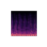

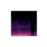

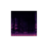

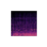

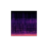

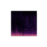

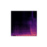

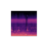

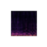

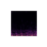

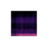

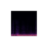

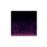

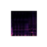

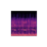

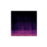

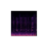

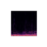

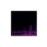

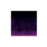

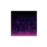

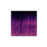

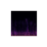

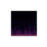

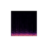

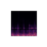

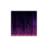

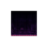

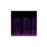

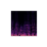

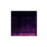

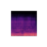

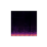

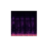

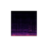

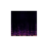

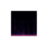

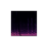

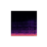

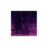

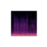

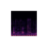

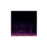

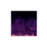

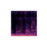

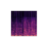

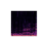

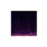

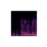

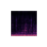

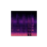

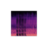

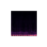

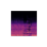

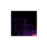

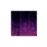

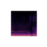

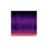

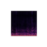

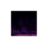

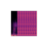

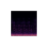

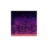

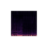

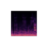

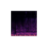

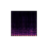

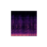

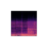

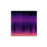

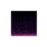

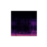

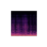

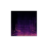

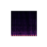

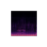

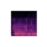

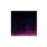

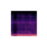

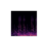

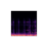

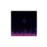

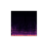

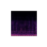

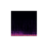

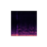

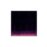

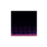

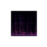

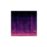

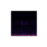

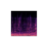

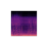

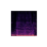

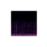

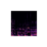

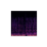

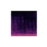

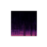

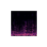

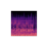

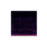

In [ ]:
image_counts = FGSM(image_counts,trainloader)
print(image_counts)

In [ ]:
image_counts

[102, 102, 102, 102, 102, 102, 102, 102, 99, 102]